# This project is for a closed competition hosted by Google to create a movie recommender system based on an IMDB datset.

## Team: HappyMiners_LA
### Team Members: 
- #### Blessing Nwogu
- #### Diana Castillo
- #### Gila Kohanbash
- #### Rachel Finley

#### This notebook was authored by Rachel Finley

## References:

### Coding references: 
- https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook
- https://www.youtube.com/watch?v=ueKXSupHz6Q
- https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor (scroll down to Sklearn API section)
- https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
- https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c


### BTT Competition Reference:
  - @misc{breakthrough-tech-ai-studio-challenge,
    author = {Christian McIntire, Hari Raghavan, Ilan Bigio, Ilan Bigio Personal, inversion, Mango Vemulapati, Paul Stephenson, Saritajoshi-google, Stephanie Gomez, Walter Reade},
    title = {BTTAI x Google Spring 2023 AI Studio Competition},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/breakthrough-tech-ai-studio-challenge}}


# Import Libraries

### Begin with neccesary imports

In [6]:
#import some necessary librairies

# Standard Linalg and Data Processing Libs
import numpy as np 
import pandas as pd 

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Ignore warning messages (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

# For some statistics
from scipy import stats
from scipy.stats import norm, skew  

# Nice libraries for the initial data cleanup that we need to do
import ast # Used to parse 'string-ified' dictionaries

# Nessecary NLP library
import re 

# Having a progress bar where applicable is always a plus!
import time
from tqdm.notebook import tqdm_notebook as tqdm

# for label encoding!

from sklearn.preprocessing import LabelEncoder


# Initial Prep, EDA, Data Cleanup, and Preprocessing

## Loading in and cleaning up the files given by competition.
We were provided with 4 csv files separated into two categories:
- #### Product Information
- Metadata
- Keywords
- #### User Information
- Train
- Test

There is an IMDB movie ID that links the product data and user data. All we have as far as User information goes is the aforementioned movie ID and a User ID. 
There is lots of nested data within the Metadata and Keywords files that we will have to extract to make use of their features. I am going to begin with that task before moving on to EDA.

### Metadata Initial Cleanup

#### I've gone and inspected the CSV files already, and we will need to extract the information from: belongs to collection, genres, spoken languages, and production companies. 
##### NOTE: I had already created these functions separately beforehand at the beginning of this competition.

In [2]:
def expand_production_studio_id(df):
    '''Function to expand production studio IDs from a column containing a list of dictionaries'''
    
    # Creating a new column for the production studio ID
    df['production_studio_id'] = ''
    
    # Iterating through the dataframe with the itertuples method, which is faster than iterrows
    for row in tqdm(df.itertuples(), desc = 'Production Studio'):
        
        # Checking if the production_companies value is NaN
        if pd.isna(row.production_companies):
            continue
        
        # Using ast to parse the stringified list of dictionaries
        studio_data = ast.literal_eval(row.production_companies)
        
        # Extracting the ID of the first production studio
        if len(studio_data) > 0:
            studio_id = studio_data[0]['id']
        else:
            studio_id = ''
        
        # Setting the production studio ID for the current row
        df.at[row.Index, 'production_studio_id'] = studio_id
        
    # Dropping the original column containing the list of dictionaries
    df.drop(columns=['production_companies'], inplace=True)
    
    # Returning the expanded dataframe
    return df

In [3]:
def expand_production_country(df):
    '''Function to extract production country from a column containing a list of dictionaries'''
    
    # Creating a new column for the production country
    df['production_country'] = ''
    
    # Iterating through the dataframe with the itertuples method, which is faster than iterrows
    for row in tqdm(df.itertuples(), desc = 'Production Country'):
        
        # Checking if the production_countries value is NaN
        if pd.isna(row.production_countries):
            continue
        
        # Using ast to parse the stringified list of dictionaries
        country_data = ast.literal_eval(row.production_countries)
        
        # Extracting the iso_3166_1 value from the first dictionary
        if len(country_data) > 0:
            country_iso = country_data[0]['iso_3166_1']
        else:
            country_iso = ''
        
        # Setting the production country for the current row
        df.at[row.Index, 'production_country'] = country_iso
        
    # Dropping the original column containing the list of dictionaries
    df.drop(columns=['production_countries'], inplace=True)
    
    # Returning the expanded dataframe
    return df


In [4]:
def expand_spoken_languages(df):
    '''Function to extract spoken languages from a column containing a list of dictionaries'''
    
    # Creating a new column for the spoken languages
    df['spoken_language'] = ''
    
    # Iterating through the dataframe with the itertuples method, which is faster than iterrows
    for row in tqdm(df.itertuples(),  desc = 'Spoken Languages'):
        
        # Checking if the spoken_languages value is NaN
        if pd.isna(row.spoken_languages):
            continue
        
        # Using ast to parse the stringified list of dictionaries
        language_data = ast.literal_eval(row.spoken_languages)
        
        # Extracting the iso_639_1 value from the first dictionary
        if len(language_data) > 0:
            language_iso = language_data[0]['iso_639_1']
        else:
            language_iso = ''
        
        # Setting the spoken language for the current row
        df.at[row.Index, 'spoken_language'] = language_iso
        
    # Dropping the original column containing the list of dictionaries
    df.drop(columns=['spoken_languages'], inplace=True)
    
    # Returning the expanded dataframe
    return df

In [5]:
def retrieve_nested_data_metadata(df):
    '''Function to Retrieve the nested data in the Metadata file'''
    
    # Creating column names to account for the amount of sub-categories within each entry
    col_names = ['genre_id_1', 'genre_name_1',
                 'genre_id_2', 'genre_name_2', 
                 'genre_id_3', 'genre_name_3', 
                 'genre_id_4', 'genre_name_4', 
                 'genre_id_5', 'genre_name_5', 
                 'genre_id_6', 'genre_name_6', 
                 'genre_id_7', 'genre_name_7',
                 'genre_id_8', 'genre_name_8']
    
    # Adding those columns to the dataframe
    df = df.reindex(columns = df.columns.tolist() + col_names)
    
    # Iterating through the dataframe with the iterrows method (its kinda like enumerate for DF's), 
    # using tqdm as a timer. Index from the "enumeration" is helpful for multi-indexing later.
    for index, row in tqdm(df.iterrows(), desc = 'Genres'):
        
        # Using ast library to evaluate a string formatted as a dictionary, which basically typecasts. 
        ## ast library works better than python's eval method IMO.
        genre_data = ast.literal_eval(row[3])
        
        # Using enumerate here to be able to perform efficient multi-indexing.
        for counter, dictionary in enumerate(genre_data, start = 1):
            
            # By using a dict based for loop, and if/else block makes this multi-indexing easier, and allows
            # for us to easily assign values to DF rows based on our conditional. NOTE: df.loc is the best
            # way to multi-index through a DF that I have found. (had errors trying to use list-like multi-indexing,
            # (ie) df['col']['index'])
            for key, value in dictionary.items():
                if key == 'id':
                    df.loc[index, f'genre_id_{counter}'] = value

                elif key == 'name':
                    df.loc[index, f'genre_name_{counter}'] = value

    # Creating column names to account for the amount of sub-categories within each entry
    col_names = ['collection_id', 'part_of_collection']
    
    # Adding those columns to the dataframe
    df = df.reindex(columns = df.columns.tolist() + col_names)
    
    # Iterating through the dataframe with the iterrows method, using tqdm as a timer. Don't need to multi-index this time.
    for index, row in tqdm(df.iterrows(), desc = 'Belongs to Collection'):
        
        # Using a try/ except suite since ast's eval methods throw an error for the various NaN entries in the column.
        try:
            
            # Using ast library to evaluate a string formatted as a dictionary, which basically typecasts. 
            ## ast library works better than python's eval method IMO.
            collection_data = ast.literal_eval(row[1])
            
            # Same idea here with the key, value for loop, making it easier to assign specific cells.
            for key, value in collection_data.items():
   
                if key == 'id':
                    df.loc[index, 'collection_id'] = value

                elif key == 'name':
                    df.loc[index, 'part_of_collection'] = value
        
        # Here the pass statement is just making it so that we skip over each row with NaN values
        except ValueError:
            pass
    
    # Drop original nested columns
    to_drop = ['belongs_to_collection', 'genres']
    df.drop(columns = to_drop, inplace = True)
        
    # Here the other three functions created at other times get implemented.
    df = expand_production_studio_id(df)
    df = expand_production_country(df)
    df = expand_spoken_languages(df)
    
    # Drop Columns useless to our final product.
    to_drop_2 = ['imdb_id', 'homepage', 'poster_path']
    df.drop(columns = to_drop_2, inplace = True)
    
    # Rename id to movieId to match user data
    df = df.rename(columns = {"id": "movieId"})
    
    # Returning our expanded dataframe!
    return df

#### Load in and expand out the metadata from the CSV file

In [6]:
metadata = pd.read_csv("movies_metadata.csv", encoding = 'utf-8')

metadata = retrieve_nested_data_metadata(metadata)
metadata.head(1)

Genres: 0it [00:00, ?it/s]

Belongs to Collection: 0it [00:00, ?it/s]

Production Studio: 0it [00:00, ?it/s]

Production Country: 0it [00:00, ?it/s]

Spoken Languages: 0it [00:00, ?it/s]

,adult,budget,movieId,original_language,original_title,overview,popularity,release_date,revenue,runtime,...,genre_name_6,genre_id_7,genre_name_7,genre_id_8,genre_name_8,collection_id,part_of_collection,production_studio_id,production_country,spoken_language
0,False,30000000,1,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,...,NaN,NaN,NaN,NaN,NaN,10194.0,Toy Story Collection,3,US,en


## Metadata Preprocessing and Analysis

### Check for missing data and zeros
First things first, lets check for missing data before moving unto more complex tasks.

In [7]:
def count_percent_nan(df, cols):
    '''Calculating Missing Data Totals and Percentages for each Feature and visualizing the results'''
    
    total = df.isnull().sum().sort_values(ascending = True)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = True)
    missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    return missing_data

In [8]:
count_percent_nan(metadata, metadata.columns)

,Total,Percent
adult,0,0.000000
production_studio_id,0,0.000000
production_country,0,0.000000
original_title,0,0.000000
spoken_language,0,0.000000
budget,0,0.000000
movieId,0,0.000000
popularity,3,0.000066
revenue,3,0.000066
title,3,0.000066


- Lets Visualize the NaN values

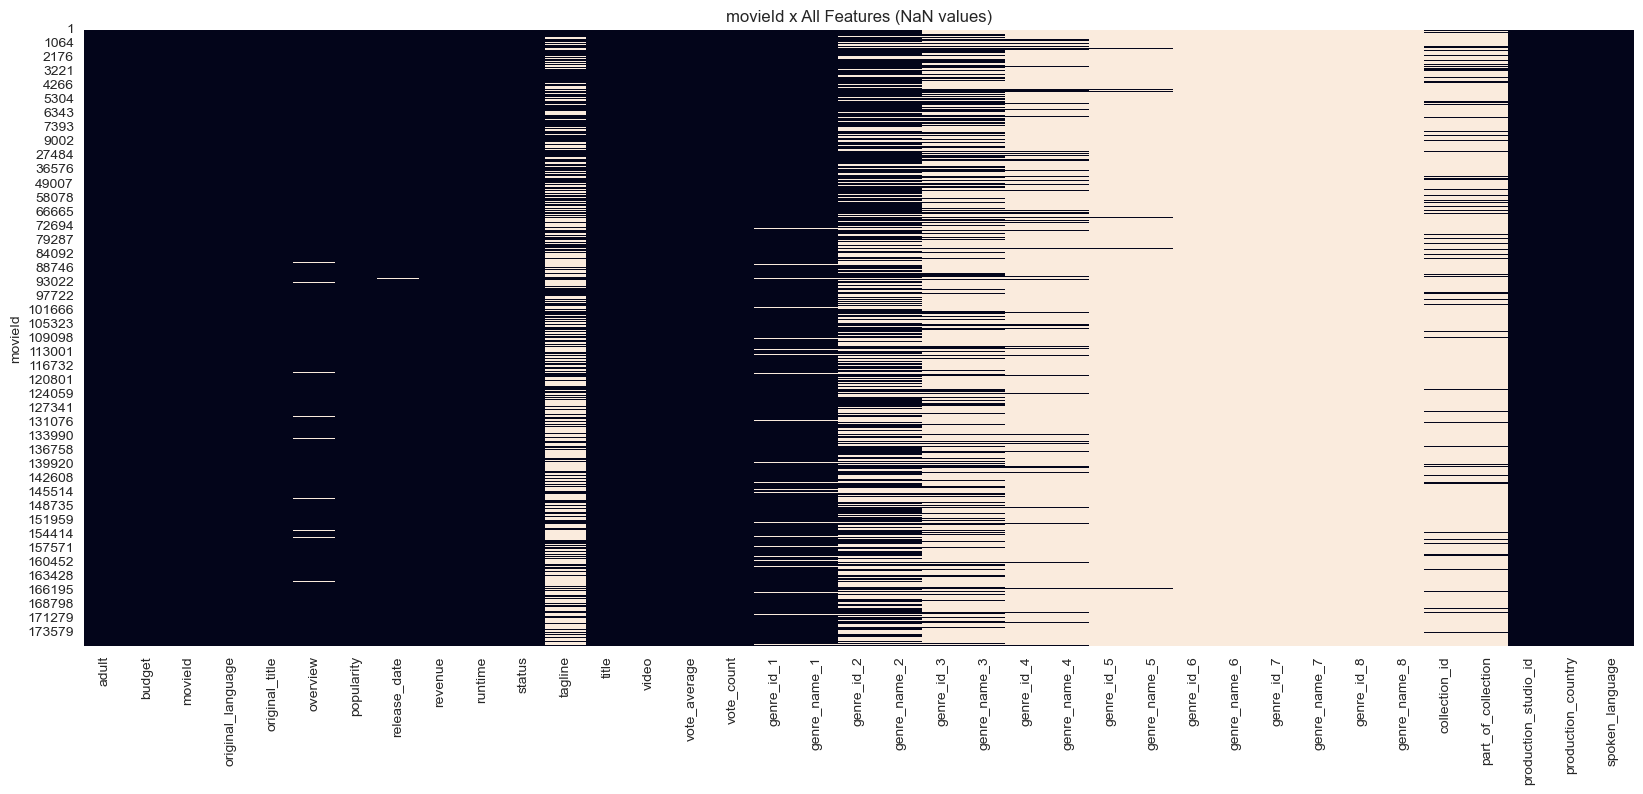

In [9]:
# Create a binary DataFrame where 1 indicates a NaN value and 0 indicates a non-NaN value
binary_nan_metadata = metadata.isnull().astype(int)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_nan_metadata.set_index(metadata['movieId']), cbar = False, ax = ax).set_title("movieId x All Features (NaN values)")
ax.set_ylabel('movieId')
plt.show()

- Here, all of the NaN-values are the beige color. A lot of these results are confirming my basic theories. Most of the missing data comes from the text data as well as the categorical data.
- There's not too much we can can do in the way of imputing these NaN-Values. Possibly testing various embedding techniques + truncation, then using various imputing techniques before checking label correlation
- I am going to test using just one of the genre columns with label encoding vs combining the text data, creating a TFIDF, and truncating it; then I will compare model performance.

#### An exploration of just NaN values could be misleading. Lets check for zero values as well!
- I am going to change release date into a release year column as well

In [10]:
# Getting rid of the day/ month parts of the release_date column, then replacing 'nan' strings with 0 before typecasting to int

metadata['release_date'] = metadata['release_date'].astype(str).apply(lambda x: re.sub('[\-]\d\d[\-]\d\d', '', x).strip())
metadata['release_date'] = metadata['release_date'].astype(str).apply(lambda x: re.sub('nan', '0', x).strip())
metadata['release_date'] = metadata['release_date'].astype(int)
metadata = metadata.rename(columns = {'release_date' : 'release_year'})

- Create a function for counting the amount of zeroes within a given list of columns of our dataframe

In [11]:
def count_percent_zeros(df, cols):
    '''Calculating zero value totals and percentages for each Feature and visualizing the results'''

    total_zeros = (df[cols] == 0).sum().sort_values(ascending=False)
    percent_zeros = (total_zeros / df[cols].count()).sort_values(ascending=False)
    zero_data = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total', 'Percent'])
    return zero_data

In [12]:
# Print the initial size of metadata and the zero values information

print(f'Initial Size of Metadata: {metadata.shape}')
count_percent_zeros(metadata, metadata.columns)

Initial Size of Metadata: (45383, 37)


,Total,Percent
adult,45375,0.999824
video,45287,0.997951
revenue,37975,0.836822
budget,36500,0.804266
vote_average,2978,0.065624
vote_count,2879,0.063442
runtime,1548,0.034305
release_year,81,0.001785
popularity,63,0.001388
genre_name_5,0,0.000000


- In an inital observation, I can see that both Video and Adult, which are binary values, consisting almost entirely of 0 values. This is not going to have any benefit for us by way of adding predictability to the dataset, so I am going to go ahead and drop them.

In [13]:
metadata.drop(columns = ['adult', 'video'], inplace = True)

- Lets visualize our 0's

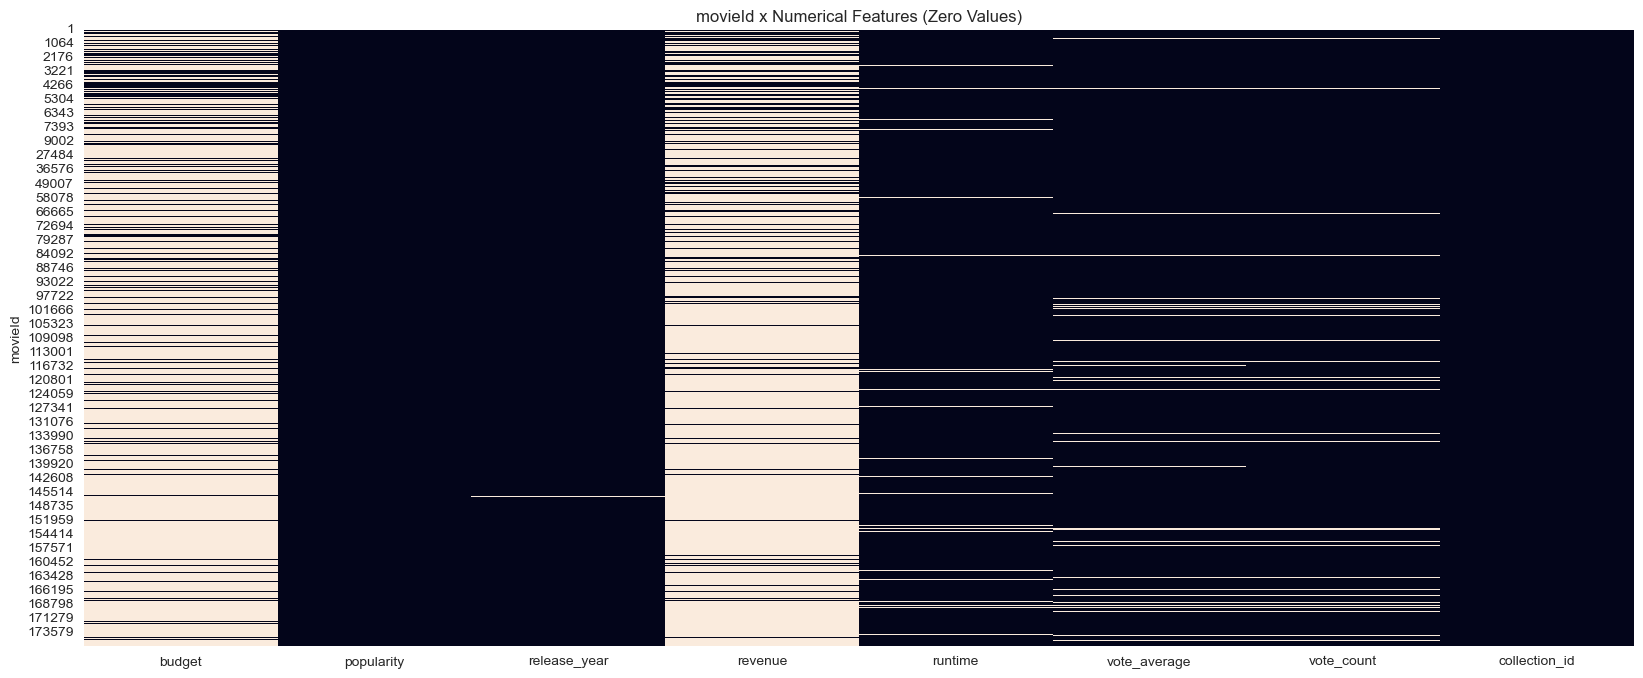

In [14]:
# Create a filtered DataFrame without the 'movieId' column
metadata_filtered = metadata.drop(columns=['movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3',
                                           'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8'])

# Select only numeric columns from the filtered DataFrame
metadata_numeric = metadata_filtered.select_dtypes(include= [int,float])

# Create a binary DataFrame where 1 indicates a zero value and 0 indicates a non-zero value
binary_metadata = (metadata_numeric == 0)

# Create a heatmap where beige indicates 0 values.
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_metadata.set_index(metadata['movieId']), cbar = False, ax=ax).set_title("movieId x Numerical Features (Zero Values)")
ax.set_ylabel('movieId')
plt.show()

- Here again beige is an indicator of our missing values. (Considering 0 values as missing)
- I am going to begin by imputing budget and revenue  with their mean values based on the release year
- Then, fill the rest of the year columns with mean year based on budget.
- In all of the tests I had run, that was the best hueristic. The initial notion was to impute the data in a way that adjusted for inflation.
- I will test correlation between popularity and vote_count and vote_average as well as other variables to see which is the best way to fill the data

- It is my opinion that the best way to start would be to handle outliers, and then impute values

#### Imputing Budget, Revenue, and Release Year

In [15]:
cols = ['budget', 'revenue', 'release_year']
count_percent_zeros(metadata, cols)

,Total,Percent
revenue,37975,0.836822
budget,36500,0.804266
release_year,81,0.001785


In [16]:
def replace_zero_with_average(df, col):
    '''Replace zero values in the budget column with the average budget for the given release year.'''

    # Calculate the average value for each release date
    avg = df.groupby('release_year')[col].mean()

    # Replace 0 values in the column with the average for that release year
    df[col] = df.apply(lambda row: row[col] if row[col] != 0 else avg[row['release_year']], axis = 1)

    return df

In [17]:
replace_zero_with_average(metadata, col = 'budget')
replace_zero_with_average(metadata, col = 'revenue')
metadata.head(1)

,budget,movieId,original_language,original_title,overview,popularity,release_year,revenue,runtime,status,...,genre_name_6,genre_id_7,genre_name_7,genre_id_8,genre_name_8,collection_id,part_of_collection,production_studio_id,production_country,spoken_language
0,30000000.0,1,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995,373554033.0,81.0,Released,...,NaN,NaN,NaN,NaN,NaN,10194.0,Toy Story Collection,3,US,en


In [18]:
cols = ['budget', 'revenue']
count_percent_zeros(metadata, cols)

,Total,Percent
revenue,302,0.006655
budget,193,0.004253


- Fill the rest of the zeros with the mean of each column.

In [19]:
for col in cols:
    metadata[col] =  metadata[col].replace(0, metadata[col].mean())

In [20]:
cols = ['budget', 'revenue', 'release_year']
count_percent_zeros(metadata, cols)

,Total,Percent
release_year,81,0.001785
budget,0,0.000000
revenue,0,0.000000


- I wanted to replace missing release year values depending on the median release date for films with similar budgets, without success.
- After trying many different methods to no avail, I am just going to fill the remaining release year columns with the median year since the amount of 0 values is near in consequntial, but 0 is a serious outlier to values in the thousands.

In [21]:
metadata['release_year'] =  metadata['release_year'].replace(0, metadata['release_year'].median())

In [22]:
cols = ['budget', 'revenue', 'release_year']
count_percent_zeros(metadata, cols)

,Total,Percent
budget,0,0.0
revenue,0,0.0
release_year,0,0.0


#### Imputing Vote Average and Vote Count

- Now, for some tests to see which method would be the best method to replace missing or zero value vote average and vote count variables.
- We will do this using a heatmap to compare levels of correlation

In [23]:
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,2978,0.065624
vote_count,2879,0.063442


- I will start by imputing the vote count ("0") values with the median vote count grouped by revenues within a certain level of tolerance

In [24]:
def replace_zero_with_median(df, col_to_impute, col_for_median, tolerance):
    """Replace "0" values in the specified column with the median value for
    similar values in another specified column, within a certain level of tolerance. """

    # Calculate the median for the specified column for each value in the specified column
    median_values = df.groupby(col_for_median)[col_to_impute].median()

    # Function to find the closest value in the specified column to a given value within a certain range
    def find_closest_value(value):
        if tolerance is None:
            return median_values.index[median_values.index == value][0]
        else:
            filtered_values = median_values.index[(median_values.index >= (1 - tolerance) * value) &
                                                  (median_values.index <= (1 + tolerance) * value)]
            if len(filtered_values) == 0:
                return None
            return filtered_values[np.abs(filtered_values - value).argmin()]

    # Replace "0" values in the specified column with the median value for
    # similar values in the specified column
    df[col_to_impute] = df.apply(
        lambda row: row[col_to_impute] if row[col_to_impute] != 0 else median_values[find_closest_value(row[col_for_median])],
        axis=1
    )

    return df

In [25]:
metadata = replace_zero_with_median(metadata, 'vote_count', 'budget', tolerance = 0.1)
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,2978,0.065624
vote_count,60,0.001322


- Replace rest of vote counts with median of vote counts

In [26]:
metadata['vote_count'] = metadata['vote_count'].replace(0, metadata['vote_count'].median())

In [27]:
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,2978,0.065624
vote_count,0,0.000000


- Moving onto Vote average, and performing the same techniques.

In [28]:
metadata = replace_zero_with_median(metadata, 'vote_average', 'revenue', tolerance = .1)
cols = ['vote_count', 'vote_average']
count_percent_zeros(metadata, cols)

,Total,Percent
vote_average,78,0.001719
vote_count,0,0.000000


In [29]:
metadata['vote_average'] = metadata['vote_average'].replace(0, metadata['vote_average'].median())
count_percent_zeros(metadata, cols)

,Total,Percent
vote_count,0,0.0
vote_average,0,0.0


#### Do a quick check for remaining 0 values

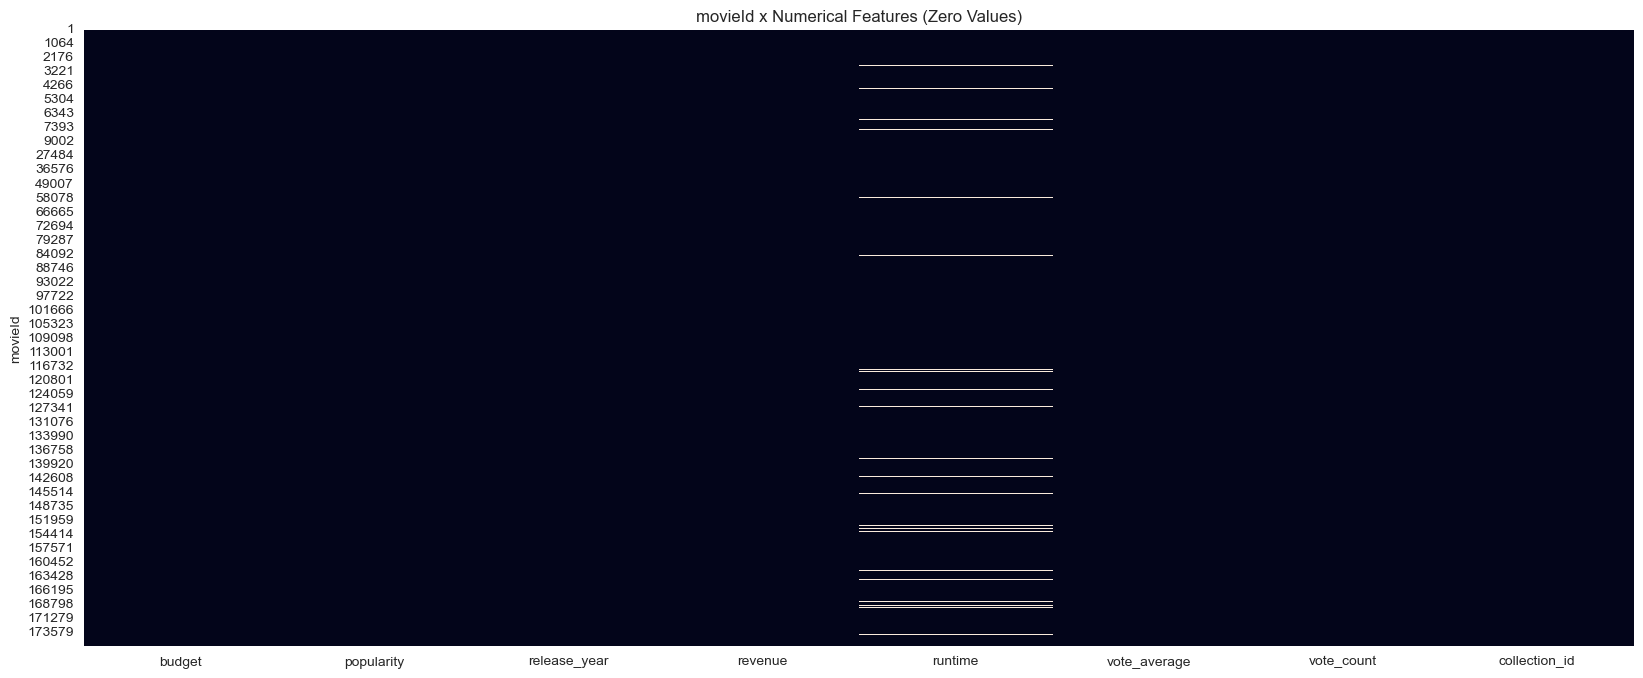

In [30]:
# Create a filtered DataFrame without the 'movieId' column
metadata_filtered = metadata.drop(columns=['movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3',
                                           'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8'])

# Select only numeric columns from the filtered DataFrame
metadata_numeric = metadata_filtered.select_dtypes(include= [int,float])

# Create a binary DataFrame where 1 indicates a zero value and 0 indicates a non-zero value
binary_metadata = (metadata_numeric == 0)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_metadata.set_index(metadata['movieId']), cbar = False, ax=ax).set_title("movieId x Numerical Features (Zero Values)")
ax.set_ylabel('movieId')
plt.show()

#### Fill runtime na's with mode runtimes based on release year.

In [31]:
numeric_cols = ['runtime', 'popularity', 'budget', 'release_year', 'revenue', 'vote_average', 'vote_count', 'collection_id']

In [32]:
metadata = replace_zero_with_average(metadata, col = 'runtime')

##### Fill the rest with average

In [33]:
count_percent_zeros(metadata, numeric_cols)

,Total,Percent
popularity,63,0.001388
runtime,1,0.000022
budget,0,0.000000
release_year,0,0.000000
revenue,0,0.000000
vote_average,0,0.000000
vote_count,0,0.000000
collection_id,0,0.000000


In [34]:
metadata['runtime'] =  metadata['runtime'].replace(0, metadata['runtime'].mean())

In [35]:
metadata['popularity'] =  metadata['popularity'].replace(0, metadata['popularity'].mean())

In [36]:
count_percent_zeros(metadata, numeric_cols)

,Total,Percent
runtime,0,0.0
popularity,0,0.0
budget,0,0.0
release_year,0,0.0
revenue,0,0.0
vote_average,0,0.0
vote_count,0,0.0
collection_id,0,0.0


#### Sanity Checking results

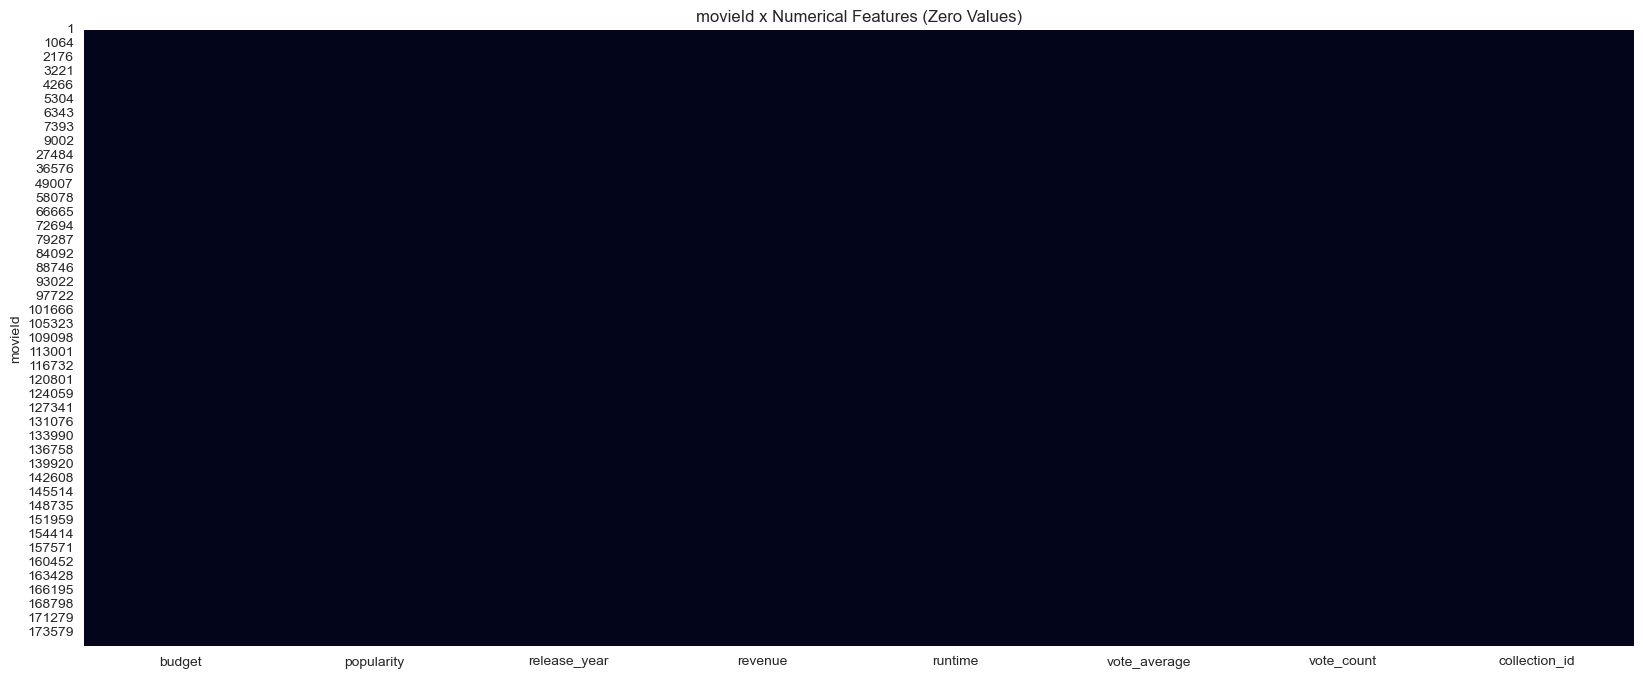

In [37]:
# Create a filtered DataFrame without the 'movieId' column
metadata_filtered = metadata.drop(columns=['movieId', 'genre_id_1', 'genre_id_2', 'genre_id_3',
                                           'genre_id_4', 'genre_id_5', 'genre_id_6', 'genre_id_7', 'genre_id_8'])

# Select only numeric columns from the filtered DataFrame
metadata_numeric = metadata_filtered.select_dtypes(include= [int,float])

# Create a binary DataFrame where 1 indicates a zero value and 0 indicates a non-zero value
binary_metadata = (metadata_numeric == 0)

# Create the heatmap with 'movieId' as y-axis values and showing the color legend
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(binary_metadata.set_index(metadata['movieId']), cbar = False, ax=ax).set_title("movieId x Numerical Features (Zero Values)")
ax.set_ylabel('movieId')
plt.show()

- This is a really wonderful thing to see!
- The model I am using, XGBoost, is typically pretty good at accounting for missing and 0 values within a dataset. However, the value of imputing our missing data with problem-specific heuristics cannot be overstated.

### Combining all genre columns into a single column to be turned into a TFIDF matrix later, and dropping the rest of the data.

- Dropping genreIds and then saving all genres into a concactenated column to a CSV

In [38]:
for i in range(1, 9):
    metadata.drop(columns = f'genre_id_{i}', inplace = True)

genres_cols_list = []
for i in range(1,9):
    genres_cols_list.append(f'genre_name_{i}')

In [39]:
metadata['all_genres'] = metadata[genres_cols_list].astype(str).apply('|'.join, axis = 1)

# Splitting the keywords at the delimiter, and removing nan values.
metadata['all_genres'] = metadata['all_genres'].astype(str).apply(lambda x: re.sub('[\|]', ' ', x).strip())
metadata['all_genres'] = metadata['all_genres'].astype(str).apply(lambda x: re.sub('nan', '', x).strip())

metadata[['movieId', 'all_genres']].to_csv("genres_concat_df.csv", index = False)
metadata.drop(columns = 'all_genres', inplace = True)
metadata.drop(columns = genres_cols_list, inplace = True)

### Label Encoding for the rest of the categorical columns

- Start by taking a count of unique values within each different feature

In [40]:
# Print counts for unique values in Studio Ids
print('Production Studio IDs:')
metadata['production_studio_id'].value_counts()

# Print counts for unique values in production_country
print('\nProduction Countries:')
print(metadata['production_country'].value_counts())

# Print counts for unique values in Original languages
print('\Original Languages:')
print(metadata['original_language'].value_counts())

# Print counts for unique values in spoken languages
print('\Spoken Languages:')
print(metadata['spoken_language'].value_counts())

Production Studio IDs:

Production Countries:
US    18410
       6254
GB     3065
FR     2701
CA     1496
      ...  
ML        1
PG        1
TZ        1
MC        1
AZ        1
Name: production_country, Length: 144, dtype: int64
\Original Languages:
en    32209
fr     2436
it     1529
ja     1345
de     1077
      ...  
ay        1
rw        1
cy        1
tg        1
si        1
Name: original_language, Length: 89, dtype: int64
\Spoken Languages:
en    26805
       3810
fr     2424
it     1410
ja     1384
      ...  
tg        1
km        1
fy        1
co        1
ff        1
Name: spoken_language, Length: 117, dtype: int64


- There are a whole lot of "one-off" languages and production countries in this dataset, so I am going to convert anything that doesnt occur at least 100 times into a 'na' value so it gets registered as the same category once encoded.

In [41]:
# Count the unique values in production_studio_id column
prod_studio_counts = metadata['production_studio_id'].value_counts()

# Select production studio IDs that have counts greater than or equal to 100
prod_studio_ids = prod_studio_counts[prod_studio_counts >= 100].index.tolist()

# Filter the dataframe to include only those which fit into that category
metadata['production_studio_id'] = metadata.apply(lambda row: row['production_studio_id'] if row['production_studio_id'] in prod_studio_ids else 0, axis = 1)

In [42]:
# Count the unique values in production_country column
prod_country_counts = metadata['production_country'].value_counts()

# Select production countries that have counts greater than or equal to 100
prod_countries = prod_country_counts[prod_country_counts >= 100].index.tolist()

# Filter the dataframe to include only those which fit into that category
metadata['production_country'] = metadata.apply(lambda row: row['production_country'] if row['production_country'] in prod_countries else 0, axis = 1)

In [43]:
# Count the unique values in original_language column
orig_lang_counts = metadata['original_language'].value_counts()

# Select original languages that have counts greater than or equal to 100
orig_languages = orig_lang_counts[orig_lang_counts >= 100].index.tolist()

# Filter the dataframe to include only those which fit into that category
metadata['original_language'] = metadata.apply(lambda row: row['original_language'] if row['original_language'] in orig_languages else 0, axis = 1)

In [44]:
# Count the unique values in production_studio_id column
counts = metadata['production_studio_id'].value_counts()

# Select counts that are greater than or equal to 100
counts = counts[counts >= 100]

# Print the selected counts
print('Production Studio IDs:')
print(counts)

# Print counts for unique values in production_country
print('\nProduction Countries:')
print(metadata['production_country'].value_counts())

# Print counts for unique values in Original languages
print('\Original Languages:')
print(metadata['original_language'].value_counts())

Production Studio IDs:
0       26405
        11837
4         997
8411      852
306       780
6194      757
33        753
5         429
441       401
6         290
60        272
2         262
12        261
5120      180
14        175
559       163
882       127
9         122
288       109
41        109
9195      102
Name: production_studio_id, dtype: int64

Production Countries:
US    18410
       6254
GB     3065
FR     2701
0      1729
CA     1496
JP     1488
IT     1470
DE     1414
RU      800
IN      779
ES      600
AU      505
HK      466
KR      456
SE      396
FI      324
BE      299
CN      299
DK      297
BR      262
PL      244
MX      235
NL      226
AR      211
CZ      163
AT      151
IE      135
TR      134
GR      131
NO      124
HU      119
Name: production_country, dtype: int64
\Original Languages:
en    32209
fr     2436
it     1529
ja     1345
de     1077
es      992
0       913
ru      825
hi      505
ko      444
zh      409
sv      384
pt      316
cn      313
fi     

- Proceed to encoding these columns into numerical categories!

In [45]:
# Fill NaN values and 0 values in the original_language column with 'na' string
metadata['original_language'] = metadata['original_language'].fillna('na')
metadata['original_language'] = metadata['original_language'].replace(0, 'na')
                                                                                          
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit and transform the original_language column using label encoding
metadata['original_language_encoded'] = le.fit_transform(metadata['original_language'])

# Print the encoded values
metadata['original_language_encoded'].value_counts()

5     32209
9      2436
12     1529
13     1345
3      1077
6       992
15      913
20      825
10      505
14      444
23      409
21      384
19      316
0       313
8       296
16      248
2       225
18      217
22      150
1       130
4       113
17      106
7       101
11      100
Name: original_language_encoded, dtype: int64

In [46]:
# Fill NaN values and 0 values in the original_language column with 'na' string
metadata['production_country'] = metadata['production_country'].fillna('na')
metadata['production_country'] = metadata['production_country'].replace(0, 'na')
                                                                                          
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit and transform the original_language column using label encoding
metadata['production_country_encoded'] = le.fit_transform(metadata['production_country'])

# Print the encoded values
metadata['production_country_encoded'].value_counts()

30    18410
0      6254
14     3065
13     2701
31     1729
6      1496
21     1488
20     1470
9      1414
27      800
19      779
11      600
3       505
16      466
22      456
28      396
12      324
4       299
7       299
10      297
5       262
26      244
23      235
24      226
1       211
8       163
2       151
18      135
29      134
15      131
25      124
17      119
Name: production_country_encoded, dtype: int64

In [47]:
# Fill NaN values and 0 values in the original_language column with 'na' string
metadata['production_studio_id'] = metadata['production_studio_id'].fillna(1)
metadata['production_studio_id'] = metadata['production_studio_id'].replace("", 1)
                                                                                          
# Instantiate a LabelEncoder object
le = LabelEncoder()

# Fit and transform the original_language column using label encoding
metadata['production_studio_id_encoded'] = le.fit_transform(metadata['production_studio_id'])

# Print the encoded values
metadata['production_studio_id_encoded'].value_counts()

0     26405
1     11837
3       997
19      852
13      780
18      757
9       753
4       429
14      401
5       290
11      272
2       262
7       261
17      180
8       175
15      163
16      127
6       122
12      109
10      109
20      102
Name: production_studio_id_encoded, dtype: int64

In [48]:
cols_to_drop = ['production_studio_id', 'production_country', 'original_language', 'spoken_language']
metadata.drop(columns = cols_to_drop, inplace = True)

- #### Lets save our progress.

In [49]:
metadata.to_csv("metadata_checkpoint.csv", index = False)

## Keywords Preprocessing

#### Run function made on earlier project expiriments made to extract nested data from the keywords columns

In [50]:
def retrieve_first_10_keywords(df):
    '''Function to retrieve the first 10 keywords for each movie in the Keywords file'''
    
    # Creating column names to account for the amount of sub-categories within each entry
    col_names = [f'keyword_id_{i}' for i in range(1, 11)]
    col_names += [f'keyword_name_{i}' for i in range(1, 11)]
    
    # Creating a list of dictionaries to store the keyword data
    keyword_list = []
    
    # Iterating through the dataframe with the iterrows method (its kinda like enumerate for DF's), 
    # using tqdm as a timer. Index from the "enumeration" is helpful for multi-indexing later.
    for index, row in tqdm(df.iterrows(), desc='keywords'):
        
        # Using ast library to evaluate a string formatted as a dictionary, which basically typecasts. 
        ## ast library works better than python's eval method IMO.
        keyword_data = ast.literal_eval(row[1])
        
        # Using enumerate here to be able to perform efficient multi-indexing.
        keywords_dict = {}
        for counter, dictionary in enumerate(keyword_data[:10], start=1):
            
            # Adding the "id" and "name" keys to a dictionary for each keyword
            keywords_dict[f'keyword_id_{counter}'] = dictionary.get('id')
            keywords_dict[f'keyword_name_{counter}'] = dictionary.get('name')
            
        # Appending the dictionary to the keyword list
        keyword_list.append(keywords_dict)
    
    # Creating a new dataframe from the keyword list
    keyword_df = pd.DataFrame(keyword_list, columns=col_names)
    
    # Concatenating the original dataframe with the keyword dataframe
    df = pd.concat([df['id'], keyword_df], axis=1)
    
    df.rename(columns = {'id': 'movieId'}, inplace = True)
    # Returning the expanded dataframe
    return df


In [51]:
keywords = pd.read_csv("movies_keywords.csv")
keywords = retrieve_first_10_keywords(keywords)

keywords: 0it [00:00, ?it/s]

#### Save all keywords into a concactenated column to a CSV

In [52]:
for i in range(1, 11):
    keywords.drop(columns = f'keyword_id_{i}', inplace = True)

keywords_cols_list = []
for i in range(1, 11):
    keywords_cols_list.append(f'keyword_name_{i}')

In [53]:
keywords['all_keywords'] = keywords[keywords_cols_list].astype(str).apply('|'.join, axis = 1)
keywords.drop(columns = keywords_cols_list, axis = 0, inplace = True)

# Splitting the keywords at the delimiter, and removing nan values.
keywords['all_keywords'] = keywords['all_keywords'].astype(str).apply(lambda x: re.sub('[\|]', ' ', x).strip())
keywords['all_keywords'] = keywords['all_keywords'].astype(str).apply(lambda x: re.sub('nan', '', x).strip())

In [54]:
keywords[['movieId', 'all_keywords']].to_csv("keywords_concat_df.csv", index = False)

## Setting up train and test datasets

### Combining together Product and User data

- #### Start with combining our newly cleaned up metadata with the train and test user data provided by the competition.

In [55]:
metadata = pd.read_csv("metadata_checkpoint.csv")

In [56]:
user_train_df = pd.read_csv("train.csv")
print("Shape of train: ")
print(f'{user_train_df.shape} \n')

user_test_df = pd.read_csv("test.csv")
print("Shape of test: ")
print(f'{user_test_df.shape} \n')

Shape of train: 
(70002, 2) 

Shape of test: 
(30002, 1) 



In [57]:
user_train_df.head()

,userId_movieId,rating
0,10_1358,0.4
1,237_1544,0.7
2,54_373,1.0
3,11_2053,0.8
4,183_2524,0.6


In [58]:
user_test_df.head()

,userId_movieId
0,469_2124
1,439_3753
2,522_1682
3,429_1217
4,71_1210


- The nessecary step of splitting userId and movieId so that we can merge by movieId

In [59]:
cols = ['userId','movieId']
user_train_df[cols] = user_train_df['userId_movieId'].str.split('_',expand=True)
user_train_df[cols] = user_train_df[cols].astype(int)
                                          
user_test_df[cols] = user_test_df['userId_movieId'].str.split('_',expand=True)
user_test_df[cols] = user_test_df[cols].astype(int)


In [60]:
user_train_df = user_train_df.drop(columns = 'userId_movieId', axis = 0)
user_train_df.head()

,rating,userId,movieId
0,0.4,10,1358
1,0.7,237,1544
2,1.0,54,373
3,0.8,11,2053
4,0.6,183,2524


In [61]:
user_test_df = user_test_df.drop(columns = 'userId_movieId', axis = 0)
user_test_df.head()

,userId,movieId
0,469,2124
1,439,3753
2,522,1682
3,429,1217
4,71,1210


- Merging the datasets

In [62]:
train_df = user_train_df.merge(metadata, on = 'movieId', how = 'left')
sub = ['userId', 'movieId']
user_train_df = user_train_df.drop_duplicates(subset = sub)
print(user_train_df.shape)
user_train_df.head()

(70002, 3)


,rating,userId,movieId
0,0.4,10,1358
1,0.7,237,1544
2,1.0,54,373
3,0.8,11,2053
4,0.6,183,2524


In [63]:
test_df = user_test_df.merge(metadata, on = 'movieId', how = 'left')
sub = ['userId', 'movieId']
user_test_df = user_test_df.drop_duplicates(subset = sub)
print(user_test_df.shape)
user_test_df.head()

(30002, 2)


,userId,movieId
0,469,2124
1,439,3753
2,522,1682
3,429,1217
4,71,1210


### Lets briefly examine our label!


 mu = 0.71 and sigma = 0.21



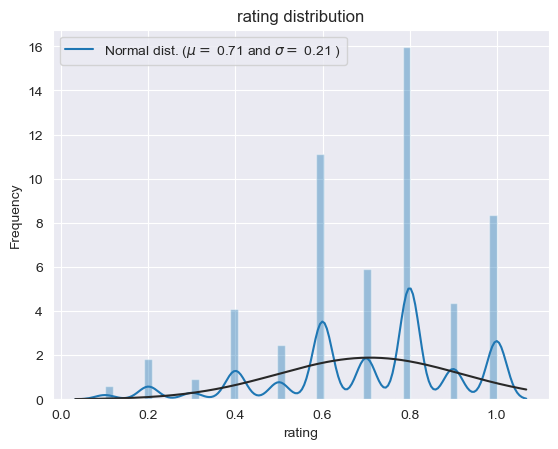

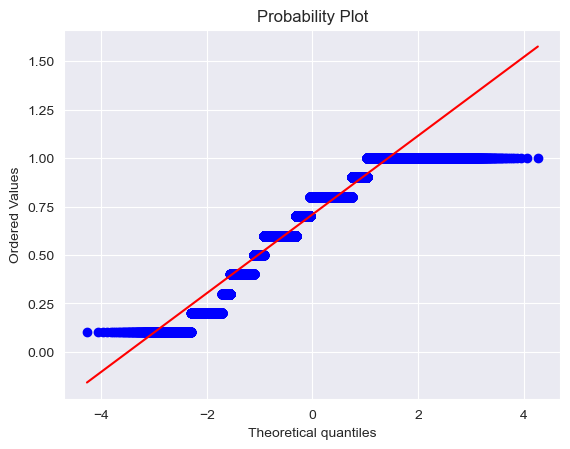

In [64]:
sns.distplot(train_df['rating'] , fit = norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['rating'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rating distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['rating'], plot=plt)
plt.show()

- #### I was thinking about applying some kind of log transformation on the label, but I'll hold off for now since there are only 10 continuous values that are being used.

## NLP Steps for text data

- #### Creating Term-Frequency Inverse Document-Frequency matricies, then decomposing them with Single Value Decomposition

### Import dependencies and set up preprocessing tasks as a function

In [65]:
import nltk
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [66]:
stemmer = PorterStemmer()

# Define a function to remove punctuation and stem words
def preprocess_text(text):
    # Remove punctuation
    no_punct = "".join([char for char in text if char not in string.punctuation])
    # Tokenize the text into words
    tokens = nltk.word_tokenize(no_punct)
    # Stem each word in the tokens list using the PorterStemmer object
    stemmed = [stemmer.stem(word) for word in tokens]
    # Join the stemmed words back into a single string
    result = " ".join(stemmed)
    return result

### Process Overview

#### Transforming data with TFIDF vectorizer

In [68]:
metadata['overview'] = metadata['overview'].fillna("").astype(str)
metadata['overview'] = metadata['overview'].apply(preprocess_text)
cols = ['overview', 'movieId']
overview = metadata[cols].copy()

In [69]:
vectorizer = TfidfVectorizer()
vectorizer.fit(overview['overview'])
tfidf_matrix_overview = vectorizer.transform(overview['overview'])

#### Selecting the optimal number of components for the SVD decomposition

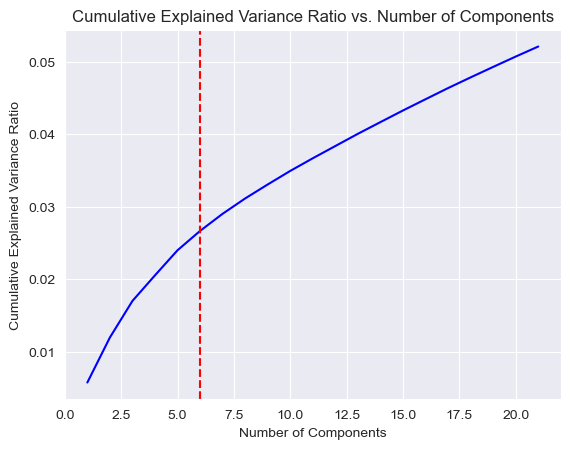

Optimal number of components: 6


In [70]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components=21)
svd_model.fit(tfidf_matrix_overview)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')

# Coordinates of the first and last points
x_coords = np.array([0, len(cumulative_variance_ratio) - 1])
y_coords = np.array([cumulative_variance_ratio[0], cumulative_variance_ratio[-1]])

# Line equation: y = m * x + b
m = (y_coords[1] - y_coords[0]) / (x_coords[1] - x_coords[0])
b = y_coords[0] - m * x_coords[0]

# Calculate the distances between the points and the line
distances = np.abs((m * np.arange(len(cumulative_variance_ratio)) - cumulative_variance_ratio + b) / np.sqrt(m ** 2 + 1 ** 2))

# Find the elbow point
elbow_point = np.argmax(distances)

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

# Print the optimal number of components
print(f"Optimal number of components: {elbow_point}")

#### Decomposing TFIDF matrix into optmal amount of features

In [71]:
svd_model = TruncatedSVD(n_components = 6)
svd_matrix_overview = svd_model.fit_transform(tfidf_matrix_overview)

In [72]:
overview = pd.merge(overview, pd.DataFrame(svd_matrix_overview), left_index = True, right_index = True)
overview.drop(columns = 'overview', inplace = True)

In [73]:
for i in range (0, 11):
    overview.rename(columns = {i: f'truncd_overview_{i}'}, inplace = True)

In [74]:
overview.head(2)

,movieId,truncd_overview_0,truncd_overview_1,truncd_overview_2,truncd_overview_3,truncd_overview_4,truncd_overview_5
0,1,0.120425,-0.017082,0.024415,0.005052,0.044686,0.045641
1,2,0.206776,-0.020307,-0.013659,0.023827,0.116842,-0.031880


### Process Tagline

#### Transforming data with TFIDF vectorizer

In [75]:
metadata['tagline'] = metadata['tagline'].fillna("").astype(str)
metadata['tagline'] = metadata['tagline'].apply(preprocess_text)
cols = ['tagline', 'movieId']
tagline = metadata[cols].copy()

In [76]:
vectorizer = TfidfVectorizer()
vectorizer.fit(tagline['tagline'])
tfidf_matrix_tagline = vectorizer.transform(tagline['tagline'])

#### Selecting the optimal number of components for the SVD decomposition

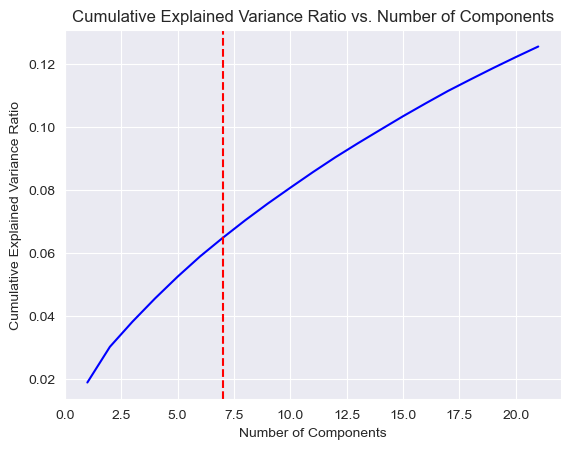

Optimal number of components: 7


In [77]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components=21)
svd_model.fit(tfidf_matrix_tagline)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')

# Coordinates of the first and last points
x_coords = np.array([0, len(cumulative_variance_ratio) - 1])
y_coords = np.array([cumulative_variance_ratio[0], cumulative_variance_ratio[-1]])

# Line equation: y = m * x + b
m = (y_coords[1] - y_coords[0]) / (x_coords[1] - x_coords[0])
b = y_coords[0] - m * x_coords[0]

# Calculate the distances between the points and the line
distances = np.abs((m * np.arange(len(cumulative_variance_ratio)) - cumulative_variance_ratio + b) / np.sqrt(m ** 2 + 1 ** 2))

# Find the elbow point
elbow_point = np.argmax(distances)

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

# Print the optimal number of components
print(f"Optimal number of components: {elbow_point}")

#### Decomposing TFIDF matrix into optmal amount of features

In [78]:
svd_model = TruncatedSVD(n_components = 7)
svd_matrix_tagline = svd_model.fit_transform(tfidf_matrix_tagline)

In [79]:
tagline = pd.merge(tagline, pd.DataFrame(svd_matrix_tagline), left_index = True, right_index = True)
tagline.drop(columns = 'tagline', inplace = True)

In [80]:
for i in range (0, 11):
    tagline.rename(columns = {i: f'truncd_tagline_{i}'}, inplace = True)

In [81]:
tagline.head(2)

,movieId,truncd_tagline_0,truncd_tagline_1,truncd_tagline_2,truncd_tagline_3,truncd_tagline_4,truncd_tagline_5,truncd_tagline_6
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.246822,-0.126964,-0.045601,0.031008,-0.050101,0.009404,0.020656


### Process Title

#### Transforming data with TFIDF vectorizer

In [82]:
metadata['title'] = metadata['title'].fillna("").astype(str)
metadata['title'] = metadata['title'].apply(preprocess_text)
cols = ['title', 'movieId']
title = metadata[cols].copy()

In [83]:
vectorizer = TfidfVectorizer()
vectorizer.fit(title['title'])
tfidf_matrix_title = vectorizer.transform(title['title'])

#### Selecting the optimal number of components for the SVD decomposition

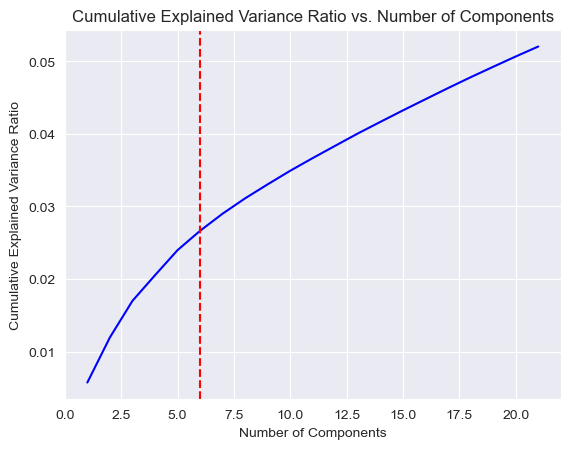

Optimal number of components: 6


In [84]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components=21)
svd_model.fit(tfidf_matrix_overview)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')

# Coordinates of the first and last points
x_coords = np.array([0, len(cumulative_variance_ratio) - 1])
y_coords = np.array([cumulative_variance_ratio[0], cumulative_variance_ratio[-1]])

# Line equation: y = m * x + b
m = (y_coords[1] - y_coords[0]) / (x_coords[1] - x_coords[0])
b = y_coords[0] - m * x_coords[0]

# Calculate the distances between the points and the line
distances = np.abs((m * np.arange(len(cumulative_variance_ratio)) - cumulative_variance_ratio + b) / np.sqrt(m ** 2 + 1 ** 2))

# Find the elbow point
elbow_point = np.argmax(distances)

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

# Print the optimal number of components
print(f"Optimal number of components: {elbow_point}")

#### Decomposing TFIDF matrix into optmal amount of features

In [85]:
svd_model = TruncatedSVD(n_components = 6)
svd_matrix_title = svd_model.fit_transform(tfidf_matrix_overview)

In [86]:
title = pd.merge(title, pd.DataFrame(svd_matrix_title), left_index = True, right_index = True)
title.drop(columns = 'title', inplace = True)

In [87]:
for i in range (0, 11):
    title.rename(columns = {i: f'truncd_title_{i}'}, inplace = True)

In [88]:
title.head(2)

,movieId,truncd_title_0,truncd_title_1,truncd_title_2,truncd_title_3,truncd_title_4,truncd_title_5
0,1,0.120425,-0.017080,0.024395,0.005004,0.044621,0.044518
1,2,0.206776,-0.020304,-0.013692,0.023737,0.117596,-0.030159


### Process Keywords

#### Transforming data with TFIDF vectorizer

In [89]:
keywords_concat = pd.read_csv("keywords_concat_df.csv")
keywords_concat['all_keywords'] = keywords_concat['all_keywords'].fillna("").astype(str)
keywords_concat['all_keywords'] = keywords_concat['all_keywords'].apply(preprocess_text)

In [90]:
vectorizer = TfidfVectorizer()
vectorizer.fit(keywords_concat['all_keywords'])
tfidf_matrix_keywords = vectorizer.transform(keywords_concat['all_keywords'])

#### Selecting the optimal number of components for the SVD decomposition

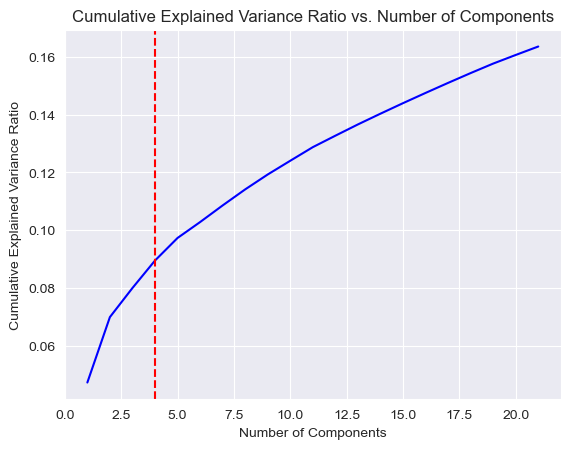

Optimal number of components: 4


In [91]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components=21)
svd_model.fit(tfidf_matrix_keywords)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')

# Coordinates of the first and last points
x_coords = np.array([0, len(cumulative_variance_ratio) - 1])
y_coords = np.array([cumulative_variance_ratio[0], cumulative_variance_ratio[-1]])

# Line equation: y = m * x + b
m = (y_coords[1] - y_coords[0]) / (x_coords[1] - x_coords[0])
b = y_coords[0] - m * x_coords[0]

# Calculate the distances between the points and the line
distances = np.abs((m * np.arange(len(cumulative_variance_ratio)) - cumulative_variance_ratio + b) / np.sqrt(m ** 2 + 1 ** 2))

# Find the elbow point
elbow_point = np.argmax(distances)

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

# Print the optimal number of components
print(f"Optimal number of components: {elbow_point}")

#### Decomposing TFIDF matrix into optmal amount of features

In [92]:
svd_model = TruncatedSVD(n_components = 4)
svd_matrix_keywords = svd_model.fit_transform(tfidf_matrix_keywords)

In [93]:
keywords_concat = pd.merge(keywords_concat, pd.DataFrame(svd_matrix_keywords), left_index = True, right_index = True)
keywords_concat.drop(columns = 'all_keywords', inplace = True)

In [94]:
for i in range (0, 4):
    keywords_concat.rename(columns = {i: f'truncd_keyword_{i}'}, inplace = True)

In [95]:
keywords_concat.head(2)

,movieId,truncd_keyword_0,truncd_keyword_1,truncd_keyword_2,truncd_keyword_3
0,1,0.002715,0.005763,0.011274,0.021426
1,2,0.004281,0.010590,0.036699,0.091159


### Process Genres

#### Transforming data with TFIDF vectorizer

In [96]:
genres_concat = pd.read_csv("genres_concat_df.csv")
genres_concat['all_genres'] = genres_concat['all_genres'].fillna("").astype(str)
genres_concat['all_genres'] = genres_concat['all_genres'].apply(preprocess_text)

In [97]:
vectorizer = TfidfVectorizer()
vectorizer.fit(genres_concat['all_genres'])
tfidf_matrix_genres = vectorizer.transform(genres_concat['all_genres'])

#### Selecting the optimal number of components for the SVD decomposition

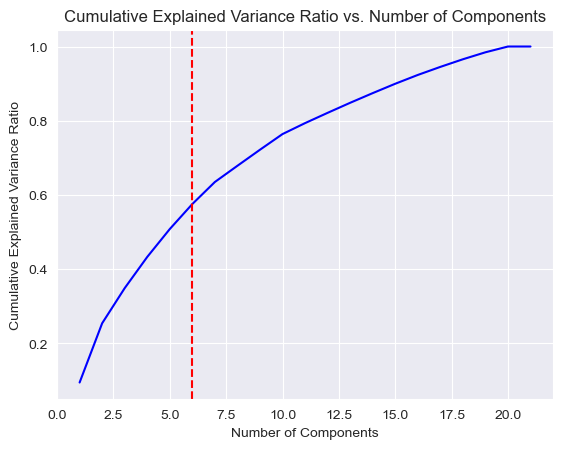

Optimal number of components: 6


In [98]:
# Fit the TruncatedSVD model
svd_model = TruncatedSVD(n_components=21)
svd_model.fit(tfidf_matrix_genres)

# Calculate the explained variance ratio for each component
variance_ratio = svd_model.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'b-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')

# Coordinates of the first and last points
x_coords = np.array([0, len(cumulative_variance_ratio) - 1])
y_coords = np.array([cumulative_variance_ratio[0], cumulative_variance_ratio[-1]])

# Line equation: y = m * x + b
m = (y_coords[1] - y_coords[0]) / (x_coords[1] - x_coords[0])
b = y_coords[0] - m * x_coords[0]

# Calculate the distances between the points and the line
distances = np.abs((m * np.arange(len(cumulative_variance_ratio)) - cumulative_variance_ratio + b) / np.sqrt(m ** 2 + 1 ** 2))

# Find the elbow point
elbow_point = np.argmax(distances)

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, linestyle='--', color='r')

# Show the plot
plt.show()

# Print the optimal number of components
print(f"Optimal number of components: {elbow_point}")

#### Decomposing TFIDF matrix into optmal amount of features

In [99]:
svd_model = TruncatedSVD(n_components = 6)
svd_matrix_keywords = svd_model.fit_transform(tfidf_matrix_genres)

In [100]:
genres_concat = pd.merge(genres_concat, pd.DataFrame(svd_matrix_keywords), left_index = True, right_index = True)
genres_concat.drop(columns = 'all_genres', inplace = True)

In [101]:
for i in range (0, 21):
    genres_concat.rename(columns = {i: f'truncd_genre_{i}'}, inplace = True)

In [102]:
genres_concat.head(2)

,movieId,truncd_genre_0,truncd_genre_1,truncd_genre_2,truncd_genre_3,truncd_genre_4,truncd_genre_5
0,1,0.221023,0.348468,0.027444,0.006154,-0.096541,-0.070590
1,2,0.074599,0.038153,0.116155,0.010183,0.017094,-0.177579


### Combine genres and keywords to then merge with our train and test data

In [103]:
genres_keywords = pd.merge(genres_concat, keywords_concat, on = 'movieId')

In [104]:
genres_keywords.head(2)

,movieId,truncd_genre_0,truncd_genre_1,truncd_genre_2,truncd_genre_3,truncd_genre_4,truncd_genre_5,truncd_keyword_0,truncd_keyword_1,truncd_keyword_2,truncd_keyword_3
0,1,0.221023,0.348468,0.027444,0.006154,-0.096541,-0.070590,0.002715,0.005763,0.011274,0.021426
1,2,0.074599,0.038153,0.116155,0.010183,0.017094,-0.177579,0.004281,0.010590,0.036699,0.091159


- Merge all product data

In [105]:
train_df =  pd.merge(train_df, overview, on = 'movieId', how = 'left')
test_df =  pd.merge(test_df, overview, on = 'movieId', how = 'left')

train_df =  pd.merge(train_df, tagline, on = 'movieId', how = 'left')
test_df =  pd.merge(test_df, tagline, on = 'movieId', how = 'left')

train_df =  pd.merge(train_df, title, on = 'movieId', how = 'left')
test_df =  pd.merge(test_df, title, on = 'movieId', how = 'left')

train_df =  pd.merge(train_df, genres_keywords, on = 'movieId', how = 'left')
test_df =  pd.merge(test_df, genres_keywords, on = 'movieId', how = 'left')

- Get rid of duplicates and unnessecary columns.

In [106]:
sub = ['userId', 'movieId']
train_df = train_df.drop_duplicates(subset = sub)
test_df = test_df.drop_duplicates(subset = sub)

In [107]:
to_drop = ['collection_id', 'part_of_collection', 'original_title', 'status', 'overview', 'tagline', 'title']

In [108]:
train_df.drop(columns = to_drop, inplace = True)
test_df.drop(columns = to_drop, inplace = True)

## Further preprocessing

### Lets check how features affect the label

In [109]:
train_df.shape

(70002, 42)

In [110]:
test_df.shape

(30002, 41)

- Examine feature/ label correlation

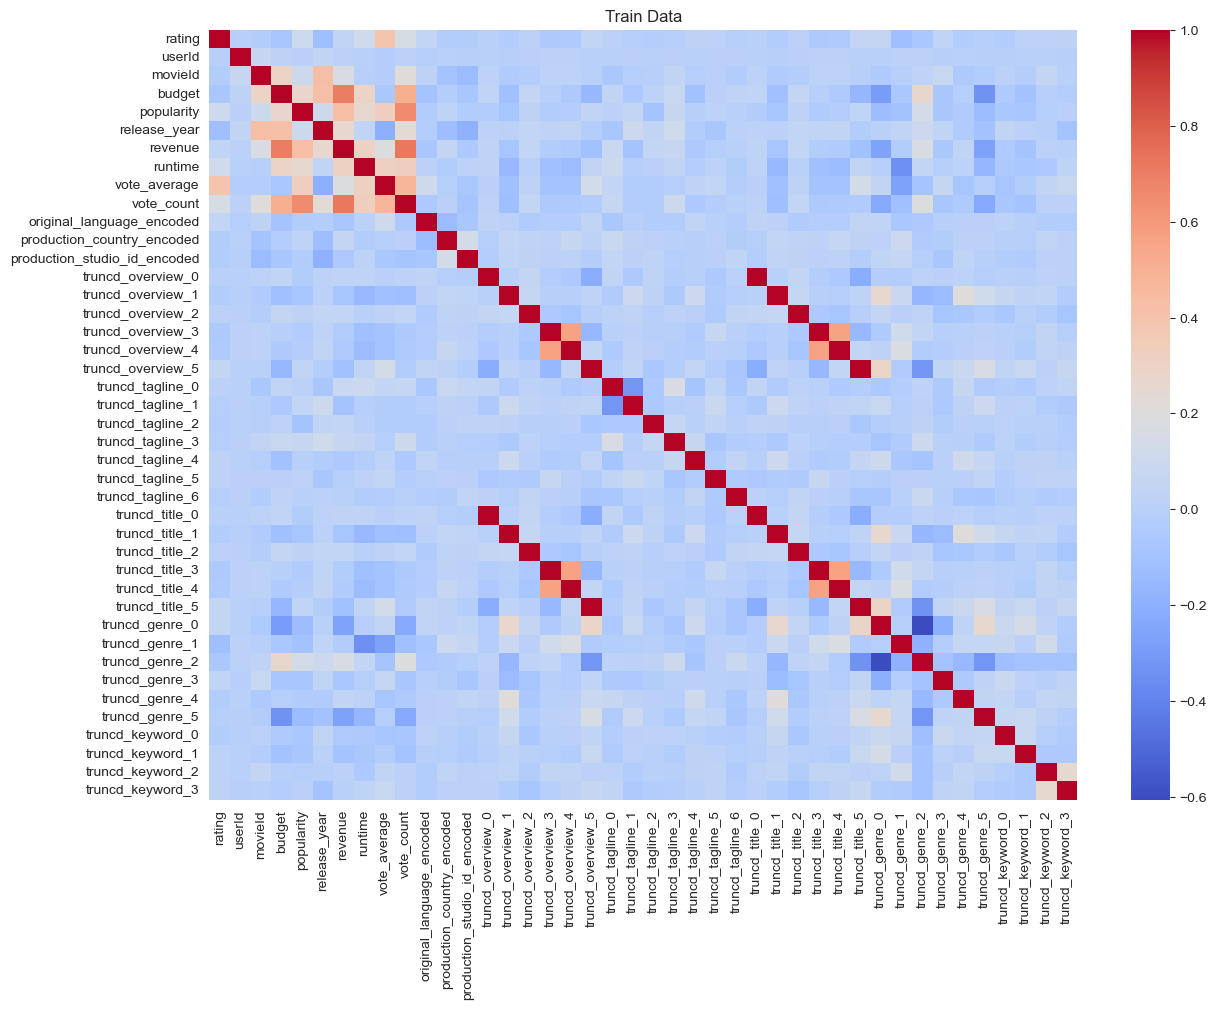

In [111]:
# Set the figure size
plt.figure(figsize=(14, 10))

# Create a heatmap of the correlations between the numeric columns
sns.heatmap(train_df.corr(), cmap = 'coolwarm', annot = False)

# Set title
plt.title('Train Data')

# Show the plot
plt.show()

- This was mostly done as a sanity check, to validate assumptions and to make sure that there isn't a debillitating amount of colinearity. 
- Mostly, there is a pretty balanced level of correlation between the label and the features, which is good for our diverse set of features. 
- What colinearity is present makes sense on a hueristic level, and I don't think is something that we would be able to get rid of without losing valuable insights for our model.

### Handling outliers for all of the numerical columns.

In [112]:
from scipy.stats import zscore

- Here we are giving ourselves the option of trying multiple different methods for outlier handling to see which works the best

- Remove outliers from numerical columns 

In [115]:
def remove_outliers(df, cols, method='mad', threshold = 3):
    """
    Remove outliers from numerical columns using various methods.
    :param method: method for outlier removal, options are 'iqr', 'zscore', 'percentile', 'mad'
    """
    new_df = df.copy()

    for col in tqdm(cols, desc='Handling Outliers'):

        # Checking for similarity within same column before caclulating
        if new_df[col].dtype != 'int64' and new_df[col].dtype != 'float64':
            continue

        if method == 'iqr':
            # Defining interquartile range
            Q1 = new_df[col].quantile(0.25)
            Q3 = new_df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Anything above or below the set range is clipped to fit it
            new_df[col] = new_df[col].clip(lower=lower_bound, upper=upper_bound)

        elif method == 'zscore':
            z_scores = np.abs(zscore(new_df[col]))
            new_df[col] = new_df[col][z_scores < threshold]

        elif method == 'percentile':
            lower_percentile = np.percentile(new_df[col], 100 * threshold / 2)
            upper_percentile = np.percentile(new_df[col], 100 - 100 * threshold / 2)
            new_df[col] = new_df[col][(new_df[col] > lower_percentile) & (new_df[col] < upper_percentile)]

        elif method == 'mad':
            median = new_df[col].median()
            mad = np.abs(new_df[col] - median).median()
            threshold_value = threshold * mad
            lower_bound = median - threshold_value
            upper_bound = median + threshold_value
            new_df[col] = new_df[col][(new_df[col] > lower_bound) & (new_df[col] < upper_bound)]

        else:
            raise ValueError(f"Method {method} not recognized for outlier removal")

    return new_df

In [116]:
cols = ['budget', 'popularity', 'release_year', 'runtime', 'vote_average', 'revenue', 'vote_count']

train_df = remove_outliers(train_df, cols)
test_df = remove_outliers(test_df, cols)

Handling Outliers:   0%|          | 0/7 [00:00<?, ?it/s]

Handling Outliers:   0%|          | 0/7 [00:00<?, ?it/s]

### Imputing the rest of the NA values, if any

In [117]:
train_df.dtypes

rating                          float64
userId                            int32
movieId                           int32
budget                          float64
popularity                      float64
release_year                    float64
revenue                         float64
runtime                         float64
vote_average                    float64
vote_count                      float64
original_language_encoded       float64
production_country_encoded      float64
production_studio_id_encoded    float64
truncd_overview_0               float64
truncd_overview_1               float64
truncd_overview_2               float64
truncd_overview_3               float64
truncd_overview_4               float64
truncd_overview_5               float64
truncd_tagline_0                float64
truncd_tagline_1                float64
truncd_tagline_2                float64
truncd_tagline_3                float64
truncd_tagline_4                float64
truncd_tagline_5                float64


- Replace both nan values and 0 values, if present, with mean of each column

In [118]:
for col in train_df.drop(columns = ['rating', 'movieId', 'userId']).columns:
    train_df[col] = train_df[col].fillna(train_df[col].mean())
    train_df[col] = train_df[col].replace(0, train_df[col].mean())

In [119]:
for col in test_df.drop(columns = ['movieId', 'userId']).columns:
    test_df[col] = test_df[col].fillna(test_df[col].mean())
    test_df[col] = test_df[col].replace(0, test_df[col].mean())

#### Sanity Check
- NaN Values

In [120]:
# Train
count_percent_nan(train_df, train_df.columns)

,Total,Percent
rating,0,0.0
truncd_tagline_4,0,0.0
truncd_tagline_5,0,0.0
truncd_tagline_6,0,0.0
truncd_title_0,0,0.0
truncd_title_1,0,0.0
truncd_title_2,0,0.0
truncd_title_3,0,0.0
truncd_title_4,0,0.0
truncd_title_5,0,0.0


In [121]:
# Test
count_percent_nan(test_df, train_df.columns)

,Total,Percent
userId,0,0.0
truncd_tagline_4,0,0.0
truncd_tagline_5,0,0.0
truncd_tagline_6,0,0.0
truncd_title_0,0,0.0
truncd_title_1,0,0.0
truncd_title_2,0,0.0
truncd_title_3,0,0.0
truncd_title_4,0,0.0
truncd_title_5,0,0.0


- Zero Values

In [122]:
# Train
count_percent_zeros(train_df, train_df.columns)

,Total,Percent
userId,159,0.002271
rating,0,0.000000
truncd_title_5,0,0.000000
truncd_tagline_4,0,0.000000
truncd_tagline_5,0,0.000000
truncd_tagline_6,0,0.000000
truncd_title_0,0,0.000000
truncd_title_1,0,0.000000
truncd_title_2,0,0.000000
truncd_title_3,0,0.000000


In [123]:
# Test
count_percent_zeros(test_df, test_df.columns)

,Total,Percent
userId,63,0.0021
truncd_tagline_3,0,0.0000
truncd_tagline_5,0,0.0000
truncd_tagline_6,0,0.0000
truncd_title_0,0,0.0000
truncd_title_1,0,0.0000
truncd_title_2,0,0.0000
truncd_title_3,0,0.0000
truncd_title_4,0,0.0000
truncd_title_5,0,0.0000


- Sweet, now that all Null and Zero values are taken care of, we are getting close to our modelling stage!
- 0 makes sense as a userId ! So, I am not worried, as it is being treated as a user

### Checking for skew in the data
- Many ml algorithms assume that the data is normally distributed. If the data is skewed, the model may not perform as well as it could. 
- So we are going to correct the skew using Box Cox technique
  - Box-Cox transform is a statistical technique that helps to transform skewed data into more normally distributed data.
  - It works by finding the best transformation of the data that maximizes the log-likelihood function.
    - Basically, it just fixes the skew of a feature

#### Train Set

In [124]:
ignore = ['rating', 'movieId', 'userId']
numeric_feats = train_df.drop(columns = ignore).dtypes[train_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_keyword_0,9.915512
truncd_keyword_2,9.401287
truncd_title_3,8.980509
truncd_overview_3,8.957675
truncd_genre_3,8.350572
truncd_keyword_1,8.303641
original_language_encoded,6.852948
truncd_keyword_3,4.263518
truncd_tagline_5,1.823613
truncd_overview_4,1.654750


In [125]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train_df[feat] += 1
    train_df[feat] = boxcox1p(train_df[feat], lam)
    
train_df[skewed_features] = np.log1p(train_df[skewed_features])

There are 39 skewed numerical features to Box Cox transform


In [126]:
ignore = ['rating', 'movieId', 'userId']
numeric_feats = train_df.drop(columns = ignore).dtypes[train_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_keyword_0,8.237191
truncd_genre_3,8.038455
truncd_keyword_2,7.471461
truncd_keyword_1,6.904168
truncd_title_3,5.550852
truncd_overview_3,5.531114
original_language_encoded,4.869183
truncd_keyword_3,3.550111
truncd_overview_4,1.420358
truncd_title_4,1.416652


#### Test Set

In [127]:
ignore = ['movieId', 'userId']
numeric_feats = test_df.drop(columns = ignore).dtypes[test_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = test_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_title_3,11.009620
truncd_overview_3,10.983283
truncd_keyword_0,9.808121
truncd_keyword_2,9.261947
truncd_keyword_1,8.560662
truncd_genre_3,8.191799
original_language_encoded,7.056270
truncd_keyword_3,4.211106
truncd_tagline_5,1.799130
truncd_overview_4,1.575715


In [128]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    test_df[feat] += 1
    test_df[feat] = boxcox1p(test_df[feat], lam)
    
test_df[skewed_features] = np.log1p(test_df[skewed_features])

There are 39 skewed numerical features to Box Cox transform


In [129]:
ignore = ['movieId', 'userId']
numeric_feats = test_df.drop(columns = ignore).dtypes[test_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = test_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
truncd_keyword_0,8.205206
truncd_genre_3,7.894429
truncd_keyword_2,7.288191
truncd_keyword_1,7.153309
truncd_title_3,6.682215
truncd_overview_3,6.660618
original_language_encoded,5.041682
truncd_keyword_3,3.546394
truncd_tagline_5,1.355397
truncd_overview_4,1.350129


In [130]:
train_df.to_csv("train_checkpoint.csv", index = False)
test_df.to_csv("test_checkpoint.csv", index = False)

# Feature Selection, Modelling, and Deployment

## Description of model: XGBRegressor

### XGBRegressor is a gradient boosting model for regression tasks. XGBoost stands for eXtreme Gradient Boosting, which is an optimized and highly efficient implementation of gradient boosting machines (GBMs). Gradient boosting is a powerful ensemble learning technique that works by fitting a sequence of weak learners (usually decision trees), where each successive learner corrects the errors made by the previous one. 

### There are several reasons why XGBRegressor was my choice for this regression task:

- Accuracy: XGBoost has demonstrated exceptional performance on a wide range of machine learning tasks, often outperforming other algorithms. Its ability to handle complex interactions between features and non-linear relationships makes it the best fit for our problem.

- Speed and Scalability: XGBoost is highly efficient and optimized for performance, making it much faster to train compared to traditional GBMs, and most other regression techniques. It uses parallel computing, among other techniques to speed up the training process, allowing it to handle large datasets like ours effectively.

- Regularization: XGBoost incorporates L1 (Lasso) and L2 (Ridge) regularization, which helps prevent overfitting and improves generalization. This regularization aspect is not present in some other gradient boosting implementations, giving XGBoost an edge in terms of model robustness . 

- Flexibility: XGBoost allows for heaps of control over its hyperparameters, which makes it highly adaptable to different tasks. This flexibility allowed me to finetune the model for the specific requirements of the movie rating prediction problem.

#### NOTE: Hyperparameter tuning has already been done in a separate Notebook

### Benefits of Recursive Feature Elimination:

- RFE can reduce the dimensionality of a dataset by removing irrelevant or redundant features, which can lead to a simpler and more efficient model.

- RFE can identify the most important features in a dataset, which can provide valuable insights into the underlying relationships between variables and improve model interpretability.

- By removing irrelevant features, RFE can help to prevent overfitting and improve model generalization.

- RFE can be used in combination with other techniques, such as our XGBRegressor, to improve model accuracy and efficiency in complex regression tasks.


## Train and Test model

- Import nessecary models

In [7]:
# XGBoost Regressor
import xgboost as xgb

# Light Gradient Boosting Machine
import lightgbm as lgb

# For feature selection
from sklearn.feature_selection import RFECV

- Load in preprocessed data

In [8]:
train_df = pd.read_csv("train_checkpoint.csv")
test_df = pd.read_csv("test_checkpoint.csv")    

In [9]:
X_train = train_df.drop(labels = 'rating', axis = 1)
y_train = train_df['rating']

X_test = test_df

In [10]:
X_train.shape

(70002, 41)

- Initialize model

In [11]:
# Set up the LightGBM model
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=1000,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    silent=True
)

In [12]:
# Set up the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=0.1,
    gamma=0.1,
    random_state=42,
    n_jobs=-1
)

In [13]:
# Use recursive feature elimination with cross-validation to select the best features
rfecv = RFECV(estimator = xgb_model, step = 1, cv = 5, scoring='neg_root_mean_squared_error', n_jobs = -1)
rfecv.fit(X_train, y_train)

# Transform the training and testing data using the selected features
X_train_rfe = rfecv.transform(X_train)
X_test_rfe = rfecv.transform(X_test)

# Train the XGBoost model on the selected features
xgb_model.fit(X_train, y_train)

# Train the LightGBM model on the selected features
lgb_model.fit(X_train, y_train)


NameError: name 'X_val' is not defined

In [15]:
test_df['rating'] = (0.6 * xgb_model.predict(test_df[X_train.columns]) + 0.4 * lgb_model.predict(test_df[X_train.columns]))
cols = ['userId', 'movieId', 'rating']
submission = test_df[cols]
submission['movieId'] = submission['movieId'].astype(int).astype (str)
submission['userId'] = submission['userId'].astype(int).astype (str)
submission['userId_movieId'] = submission['userId'] + '_' + submission['movieId']
to_drop = ['userId', 'movieId']
submission.drop(columns = to_drop, inplace = True)

In [16]:
test_df.to_csv('user_product_matrix.csv', index = False)
submission.to_csv('xgb_lgb_blend.csv', index = False)

#### Using the evaluation on 50% of the data provided by the competition,
- #### Submission RMSE score: 0.1713

## Deployment

### Recommendation System
- I thought it would be neat to implement a fully functional movie recommendation system using our model's predictions as well as some other techniques to create a hybrid system.

### Our System:

### Hybrid-Recommender

- #### Combines both collaborative filtering and content-based filtering techniques.
  - Uses XGBoost machine learning model to predict user ratings for movies.
  - Captures user preferences and movie features.
  - Predicted ratings represent a form of collaborative filtering.

- #### Computes cosine similarity between movies based on predicted ratings.
  - Represents a content-based filtering approach.
  - Measures similarity between movie rating patterns across users.
  - Recommends top n movies for a given user by:
  - Identifying most similar movies to those the user has watched.
  - Selecting movies based on highest cosine similarity scores.

- #### The goal of the system is to provide more accurate and personalized recommendations by leveraging user interactions and content-based similarities.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def create_user_product_matrix(df):
    '''Create a user-product matrix by implementing a pivot table'''
    
    user_item_matrix = df.pivot_table(index = 'userId', columns ='movieId', values = 'rating')
    return user_item_matrix

In [ ]:
def fill_missing_values(matrix):
    '''Fill any missing values that occur once the pivot table has been created'''
    
    filled_matrix = matrix.fillna(0)
    return filled_matrix

In [ ]:
def get_cosine_similarity(user_item_matrix):
    '''Calculate Cosine Similarity between different items in the user product matrix, giving us usable similarity scores'''
    
    movie_similarity = cosine_similarity(user_item_matrix.T)
    return movie_similarity

In [ ]:
def recommend_movies(data, user_id, n):
    '''Final implementation of the system'''
    
    # 
    if user_id not in data['userId'].unique():
        print(f"Error: User ID {user_id} not found in the dataset.")
        return
    
    user_product_matrix = create_user_product_matrix(data)
    user_product_matrix = fill_missing_values(user_product_matrix)  # Fill missing values
    movie_similarity = get_cosine_similarity(user_product_matrix)
    
    # Get the movies watched by the specified user
    user_movies = data[data['userId'] == user_id]

    # Find the most similar movies to the ones the user has watched
    watched_movie_ids = user_movies['movieId'].tolist()
    most_similar_movies = []
    for movie_id in watched_movie_ids:
        movie_index = user_product_matrix.columns.get_loc(movie_id)
        similarity_scores = movie_similarity[movie_index]
        most_similar_movie_index = np.argsort(similarity_scores)[-n-1:-1]  # Exclude the movie itself
        most_similar_movies += list(user_product_matrix.columns[most_similar_movie_index])

    # Remove duplicates and watched movies
    unique_similar_movies = list(set(most_similar_movies))
    recommended_movie_ids = list(set(unique_similar_movies) - set(watched_movie_ids))

    # Get the top n recommended movies based on their similarity scores
    top_movies = data[data['movieId'].isin(recommended_movie_ids)].drop_duplicates(subset = 'movieId').nlargest(n, 'rating')

    # Print the top n recommended movies with their titles
    print(f'Top {n} recommendations for user {user_id}:\n')
    for movie in top_movies["title"].values:
        print(f'{movie}')

- Create a dataset with our predictions, film titles, and user data from the test set
  - ##### We could append the training data for a larger pool from which to provide reccomendations, but I felt it salient to show that we could make recommendations for "previously unseen films" with our machine learning model

In [ ]:
cols = ['movieId', 'title']

metadata_title = pd.read_csv("metadata_checkpoint.csv")
metadata_title = metadata_title[cols]

test_data = pd.read_csv('user_product_matrix.csv')

sub = ['userId', 'movieId']
data = pd.merge(test_data, metadata_title, on = 'movieId')
data = data.drop_duplicates(subset = sub)

- Sample usages with different user id's and number of films.

In [ ]:
recommend_movies(data = data, user_id = 434, n = 10)

In [ ]:
recommend_movies(data = data, user_id = 820, n = 20)

In [ ]:
recommend_movies(data = data, user_id = 71, n = 20)


### Final Thoughts:

#### Our system seems to be working great! 
- Any further work would nessecitate a new problem statement, whether that problem statement stems from a business need, or from a desire to expiriment further.
- A theoretical next step could be to form classes for each of the different functionalities of our system so that it can become modular, and any new data can be easily processed, ratings predicted, and recommendations given. 
- We could create an information retrieval system that uses IMDB as a knowledge base to find and return a larger pool of films. That way we could implement some kind of caching system based on individual users and some kind of similarity metric, like top n genres or something, instead of downloading the entirety of IMDB
- Conversely, with enough resources we could download and preprocess the entirety of IMDB, and save it to a database for future recommendations.

Here's to hoping you enjoyed this notebook, and found somehting of value from this exploration.